In [2]:
import os
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid

In [3]:
def process_power_per_pod(folder_path):
    # Process power consumption data
    power_file = os.path.join(folder_path, "metrics_energy.json")
    uid_pod_map_file = os.path.join(folder_path, "uid_pod_mapping.csv")  # Now reading as a CSV

    # Load UID to Pod Name Mapping
    if os.path.exists(uid_pod_map_file):
        uid_pod_map = pd.read_csv(uid_pod_map_file)  # Read CSV into a DataFrame
        # Ensure the mapping DataFrame has expected columns
        if not {"UID", "Pod Name"}.issubset(uid_pod_map.columns):
            print("Invalid UID-Pod mapping format")
            return pd.DataFrame()  # Return an empty DataFrame
    else:
        print("No UID-Pod mapping file found")
        return pd.DataFrame()  # Return an empty DataFrame

    # Load Power Data
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
    else:
        print("No power data file found")
        return pd.DataFrame()  # Return an empty DataFrame
       
    # Collect timestamps and values for all pods
    rows = []
    for uid_suffix, data in power_data.items():
        # Map UID suffix to pod name using the DataFrame
        pod_name_row = uid_pod_map[uid_pod_map["UID"].str.endswith(uid_suffix)]
        if pod_name_row.empty:
            continue  # Skip if no matching UID is found
        pod_name = pod_name_row.iloc[0]["Pod Name"]  # Get the first match

        # Append each entry in the pod's power data to the rows list
        for entry in data:
            rows.append({
                "timestamp": entry["timestamp"],
                "pod_name": pod_name,
                "value": entry["value"]
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)

    return df


In [4]:
def process_folder(folder_path):
    # Extract configuration from folder name
    folder_name = os.path.basename(folder_path)
    requested_mbps, packet_length = folder_name.split('_')

    # Initialize results
    tot_mbps_received = 0  # Default if no files found
    server_durations = []  # List to store durations of all servers

    # Process iperf server log
    server_files = glob.glob(os.path.join(folder_path, "log_iperf_server_*.csv"))
    if server_files:
        for server_file in server_files:
            df_server = pd.read_csv(server_file)
            if not df_server.empty:
                # Extract the last row
                last_row = df_server.iloc[-1]
                
                # Extract Mbps from the last row
                tot_mbps_received += last_row['Transfer'] / 1e6  # Convert bps to Mbps
                
                # Extract and calculate duration from the Interval column
                interval_str = last_row['Interval']  # Example: '0.0-3.1'
                start, end = map(float, interval_str.split('-'))  # Split into start and end times
                duration = end - start  # Calculate duration
                server_durations.append(duration)  # Store the duration for this server

    # Process pod-level power data using process_power_per_pod
    df_pod_power = process_power_per_pod(folder_path)

    # Initialize aggregated power and energy consumption variables
    power_components = ['oai-cu', 'oai-du', 'oai-nr-ue', 'oai-upf']
    power_results = {component: {'baseline': 0, 'experiment': 0} for component in power_components}
    energy_results = {component: {'baseline': 0, 'experiment': 0} for component in power_components}

    # Aggregate power and energy consumption per component
    for component in power_components:
        component_pods = df_pod_power[df_pod_power["pod_name"].str.startswith(component)]
        if not component_pods.empty:
            component_pods_sorted = component_pods.sort_values(by="timestamp")
            baseline_filtered = component_pods_sorted.iloc[20:40]
            experiment_filtered = component_pods_sorted.iloc[-int(round(min(server_durations), 0)):]  # Use min duration for slicing

            # Aggregate power and energy for all pods belonging to the same component
            baseline_power_avg = baseline_filtered['value'].mean() if not baseline_filtered.empty else 0
            experiment_power_avg = experiment_filtered['value'].mean() if not experiment_filtered.empty else 0

            power_results[component]['baseline'] += baseline_power_avg
            power_results[component]['experiment'] += experiment_power_avg

            # Calculate energy as the integral of power over time (assuming equal time intervals)
            baseline_energy = trapezoid(baseline_filtered['value'], dx=1) if not baseline_filtered.empty else 0
            experiment_energy = trapezoid(experiment_filtered['value'], dx=1) if not experiment_filtered.empty else 0

            # If energy calculation is not valid, fallback to power × duration
            if experiment_energy <= 0:
                experiment_energy = experiment_power_avg * sum(server_durations)

            energy_results[component]['baseline'] += baseline_energy
            energy_results[component]['experiment'] += experiment_energy

    # Combine CPU usage (if applicable) for each component
    cpu_usages = {}
    cpu_file = os.path.join(folder_path, "metrics_cpu.json")
    if os.path.exists(cpu_file):
        with open(cpu_file, 'r') as f:
            cpu_data = json.load(f)
        
        # Aggregate CPU usage per component
        for pod_name, pod_data in cpu_data.items():
            component = next((comp for comp in power_components if pod_name.startswith(comp)), None)
            if component:
                cpu_usages.setdefault(component, [])
                for entry in pod_data:
                    cpu_usages[component].append(entry['value'])

    avg_cpu_usage = {comp: (sum(values) / len(values) if values else 0) for comp, values in cpu_usages.items()}

    # Combine the results into a single row for baseline and experiment
    baseline = {
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "tot Mbps effectively received at server": tot_mbps_received,
    }
    experiment = {
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "tot Mbps effectively received at server": tot_mbps_received,
    }

    # Add power, energy, and CPU consumption data to baseline and experiment
    for component in power_components:
        # Add power consumption data
        baseline[f"avg {component.upper()} power consumption [W]"] = power_results[component]['baseline']
        experiment[f"avg {component.upper()} power consumption [W]"] = power_results[component]['experiment']

        # Add energy consumption data
        baseline[f"total {component.upper()} energy consumption [J]"] = energy_results[component]['baseline']
        experiment[f"total {component.upper()} energy consumption [J]"] = energy_results[component]['experiment']

        # Add CPU usage data, if available
        if component in avg_cpu_usage:
            baseline[f"avg {component.upper()} CPU usage [%]"] = avg_cpu_usage[component]
            experiment[f"avg {component.upper()} CPU usage [%]"] = avg_cpu_usage[component]
    for (i,duration) in enumerate(server_durations):
        # Add durations data
        experiment[f"duration_{i+1}"] = duration


    return baseline, experiment


In [5]:
def gather_metrics_all_rates(base_folder_path):
    data_baseline = []
    data_experiment = []

    # Iterate through all maxrate levels
    for maxrate_folder in os.listdir(base_folder_path):
        maxrate_path = os.path.join(base_folder_path, maxrate_folder)

        # Check if the maxrate path is a directory
        if not os.path.isdir(maxrate_path):
            continue

        # Iterate through all pools of experiments under the maxrate level
        for experiment_pool in os.listdir(maxrate_path):
            pool_path = os.path.join(maxrate_path, experiment_pool)

            # Check if the pool path is a directory
            if not os.path.isdir(pool_path):
                continue

            # Process each folder inside the pool
            for experiment_folder in os.listdir(pool_path):
                experiment_path = os.path.join(pool_path, experiment_folder)

                if os.path.isdir(experiment_path):  # Check if it's a directory
                    # Traverse deeper into the experiment folder for specific experiments
                    for subfolder in os.listdir(experiment_path):
                        subfolder_path = os.path.join(experiment_path, subfolder)

                        if os.path.isdir(subfolder_path):  # Check if it's a directory
                            # Extract CU information from the parent folder name
                            parent_folder_name = os.path.basename(pool_path)

                            try:
                                num_cus = int(parent_folder_name.split('_')[2][0])  # Extract the number of CUs
                            except (IndexError, ValueError):
                                print(f"Could not extract CU information from folder: {parent_folder_name}")
                                continue

                            # Process the subfolder and get baseline and experiment data
                            print(f"Processing folder: {subfolder_path}")
                            baseline, experiment = process_folder(subfolder_path)

                            # Add metadata to the results
                            baseline['maxrate'] = int(maxrate_folder)
                            experiment['maxrate'] = int(maxrate_folder)
                            baseline['experiment_pool'] = experiment_pool
                            experiment['experiment_pool'] = experiment_pool
                            baseline['num_cus'] = num_cus
                            experiment['num_cus'] = num_cus

                            # Append baseline and experiment data to their respective lists
                            data_baseline.append(baseline)
                            data_experiment.append(experiment)

    # Combine baseline and experiment data into DataFrames
    df_baseline = pd.DataFrame(data_baseline)
    df_experiment = pd.DataFrame(data_experiment)

    if not df_baseline.empty:
        df_baseline = df_baseline.select_dtypes(include=[float, int])  # Keep only numeric columns
        baseline_stats = df_baseline.agg(['mean', 'std']).T
    else:
        baseline_stats = pd.DataFrame()

    if not df_experiment.empty:
        df_experiment = df_experiment.select_dtypes(include=[float, int])  # Keep only numeric columns
        experiment_stats = df_experiment.agg(['mean', 'std']).T
    else:
        experiment_stats = pd.DataFrame()

    return df_baseline, df_experiment, baseline_stats, experiment_stats


# Example usage
base_folder_path = "/home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2"

df_baseline, df_experiment, baseline_stats, experiment_stats = gather_metrics_all_rates(base_folder_path)

# Filter data if needed
df_experiment_filtered = df_experiment[df_experiment['packet length requested'].isin([500])]

df_experiment_filtered


Processing folder: /home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2/50/60_2UE_1CU_iperf-n/experiment_packet_energy_2UE_1CU_iperf-n_4/1000_500
Processing folder: /home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2/50/60_2UE_1CU_iperf-n/experiment_packet_energy_2UE_1CU_iperf-n_4/100_500
Processing folder: /home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2/50/60_2UE_1CU_iperf-n/experiment_packet_energy_2UE_1CU_iperf-n_4/500_500
Processing folder: /home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2/50/60_2UE_1CU_iperf-n/experiment_packet_energy_2UE_1CU_iperf-n_4/20_500
Processing folder: /home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2/50/60_2UE_1CU_iperf-n/experiment_packet_energy_2UE_1CU_iperf-n_4/300_500
Processing folder: /home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate2/50/60_2UE_1CU_iperf-n/e

,Mbps requested,packet length requested,tot Mbps effectively received at server,avg OAI-CU power consumption [W],total OAI-CU energy consumption [J],avg OAI-DU power consumption [W],total OAI-DU energy consumption [J],avg OAI-NR-UE power consumption [W],total OAI-NR-UE energy consumption [J],avg OAI-UPF power consumption [W],total OAI-UPF energy consumption [J],duration_1,duration_2,maxrate,num_cus
0,1000,500,1048.57600,0.225603,38.646858,6.454968,1104.300813,8.333481,1426.233118,0.592494,101.505697,190.3,171.5,50,1
1,100,500,104.85760,0.177473,2.545501,5.974109,83.561513,6.995866,97.344570,0.427667,6.076291,19.1,14.6,50,1
2,500,500,524.28800,0.200915,19.001723,6.244232,587.137952,8.066407,758.875805,0.585548,55.406456,95.1,95.0,50,1
3,20,500,20.97152,0.055830,0.167490,5.668894,17.006682,6.327878,18.983635,0.124544,0.373632,3.5,3.8,50,1
4,300,500,314.57280,0.222462,11.622214,6.184127,321.689797,7.896650,410.938238,0.548970,28.721784,52.7,57.2,50,1
5,1000,500,1048.57600,0.217795,35.337107,6.194953,1003.867568,8.169825,1324.720820,0.592668,96.181808,190.3,163.3,50,1
6,100,500,104.85760,0.160779,2.733248,5.970273,101.727315,7.065306,120.806926,0.426090,7.243534,19.0,17.7,50,1
7,500,500,524.28800,0.219364,17.220156,6.438748,502.590218,8.147146,636.165027,0.587167,46.063851,95.2,78.7,50,1
8,2000,500,2097.15200,0.220640,70.009306,6.340313,2010.260540,8.422569,2670.966336,0.612349,194.318081,380.6,318.1,50,1
9,20,500,20.97152,0.004288,0.008576,5.849570,11.655940,6.649985,13.028085,0.000000,0.000000,3.1,3.8,50,1


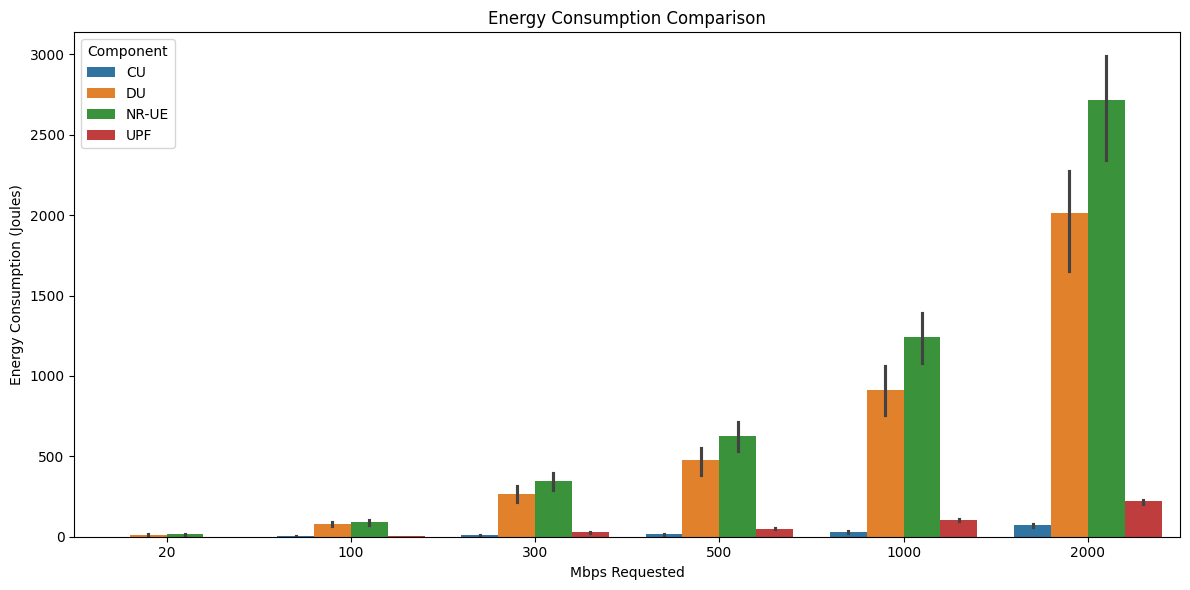

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Energy Consumption Comparison
def plot_energy_comparison(df_experiment):
    plt.figure(figsize=(12, 6))
    
    components = [
        'total OAI-CU energy consumption [J]', 
        'total OAI-DU energy consumption [J]',
        'total OAI-NR-UE energy consumption [J]', 
        'total OAI-UPF energy consumption [J]'
    ]
    
    # Filter and melt the data for easier plotting
    df_melted = df_experiment.melt(
        id_vars=['Mbps requested', 'num_cus'], 
        value_vars=components, 
        var_name='Component', 
        value_name='Energy (J)'
    )
    
    # Replace component names for clarity
    df_melted['Component'] = df_melted['Component'].str.replace(
        'total OAI-', ''
    ).str.replace(' energy consumption \\[J\\]', '', regex=True)
    
    sns.barplot(
        data=df_melted, 
        x='Mbps requested', 
        y='Energy (J)', 
        hue='Component'
    )
    
    plt.title('Energy Consumption Comparison')
    plt.xlabel('Mbps Requested')
    plt.ylabel('Energy Consumption (Joules)')
    plt.legend(title='Component')
    plt.tight_layout()
    plt.show()

plot_energy_comparison(df_experiment)


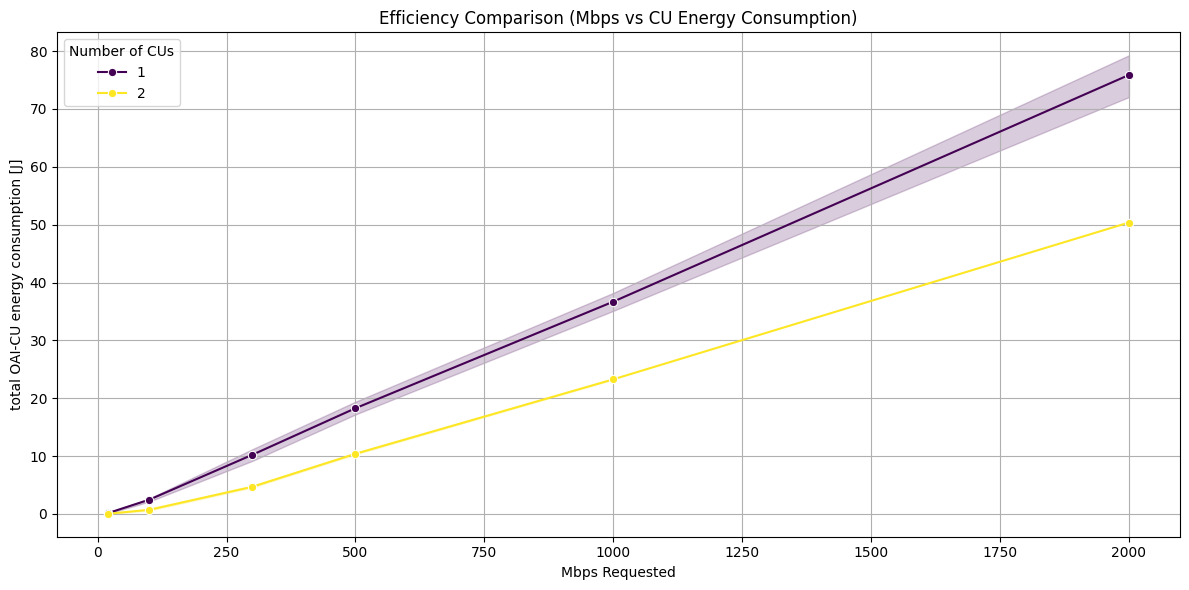

In [7]:
# Efficiency Plot
def plot_efficiency(df_experiment):
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(
        data=df_experiment, 
        x='Mbps requested', 
        y='total OAI-CU energy consumption [J]', 
        hue='num_cus', 
        marker='o', 
        palette='viridis'
    )
    
    plt.title('Efficiency Comparison (Mbps vs CU Energy Consumption)')
    plt.xlabel('Mbps Requested')
    plt.ylabel('total OAI-CU energy consumption [J]')
    plt.legend(title='Number of CUs', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the functions to plot
plot_efficiency(df_experiment)


In [8]:
df_experiment

,Mbps requested,packet length requested,tot Mbps effectively received at server,avg OAI-CU power consumption [W],total OAI-CU energy consumption [J],avg OAI-DU power consumption [W],total OAI-DU energy consumption [J],avg OAI-NR-UE power consumption [W],total OAI-NR-UE energy consumption [J],avg OAI-UPF power consumption [W],total OAI-UPF energy consumption [J],duration_1,duration_2,maxrate,num_cus
0,1000,500,1048.57600,0.225603,38.646858,6.454968,1104.300813,8.333481,1426.233118,0.592494,101.505697,190.3,171.5,50,1
1,100,500,104.85760,0.177473,2.545501,5.974109,83.561513,6.995866,97.344570,0.427667,6.076291,19.1,14.6,50,1
2,500,500,524.28800,0.200915,19.001723,6.244232,587.137952,8.066407,758.875805,0.585548,55.406456,95.1,95.0,50,1
3,20,500,20.97152,0.055830,0.167490,5.668894,17.006682,6.327878,18.983635,0.124544,0.373632,3.5,3.8,50,1
4,300,500,314.57280,0.222462,11.622214,6.184127,321.689797,7.896650,410.938238,0.548970,28.721784,52.7,57.2,50,1
5,1000,500,1048.57600,0.217795,35.337107,6.194953,1003.867568,8.169825,1324.720820,0.592668,96.181808,190.3,163.3,50,1
6,100,500,104.85760,0.160779,2.733248,5.970273,101.727315,7.065306,120.806926,0.426090,7.243534,19.0,17.7,50,1
7,500,500,524.28800,0.219364,17.220156,6.438748,502.590218,8.147146,636.165027,0.587167,46.063851,95.2,78.7,50,1
8,2000,500,2097.15200,0.220640,70.009306,6.340313,2010.260540,8.422569,2670.966336,0.612349,194.318081,380.6,318.1,50,1
9,20,500,20.97152,0.004288,0.008576,5.849570,11.655940,6.649985,13.028085,0.000000,0.000000,3.1,3.8,50,1


In [140]:
# TODO: fix this block
log_deploy_path='/home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/2CU_deployment_time_3/updated_log_deploy_cu2.csv'
df_energy_deployment = pd.read_csv(log_deploy_path)
powerup_duration=df_energy_deployment['Duration'].mean()
powerup_energy=df_energy_deployment['Energy'].mean()
print(powerup_energy)
powerup_power=8
print(powerup_duration)

96.69440272256247
15.790528904307973


In [141]:
# Constants
host_power_w = 3

# Calculate host energy consumption for each CU configuration
df_experiment['host_energy_consumption'] = df_experiment.apply(
    lambda row: (
        host_power_w * (max(row['duration_1'] , row['duration_2'] ) ) if row['num_cus'] == 1
        else host_power_w *(row['duration_1'] +  row['duration_2'] )
    ),
    axis=1
)

df_experiment['powerup_energy_consumption'] = powerup_power * powerup_duration *  df_experiment['num_cus'] 
#powerup_energy *  df_experiment['num_cus'] 


# Calculate the total energy consumption for each row (sum of all energy consumption columns)
df_experiment['service_energy_consumption_J'] = (
    df_experiment['total OAI-CU energy consumption [J]'] +
    df_experiment['total OAI-DU energy consumption [J]'] +
    df_experiment['total OAI-UPF energy consumption [J]']
)

# Update the total energy consumption to include the host energy consumption
df_experiment['total_energy_consumption'] = (
    df_experiment['service_energy_consumption_J'] + df_experiment['host_energy_consumption'] + df_experiment['powerup_energy_consumption']
)


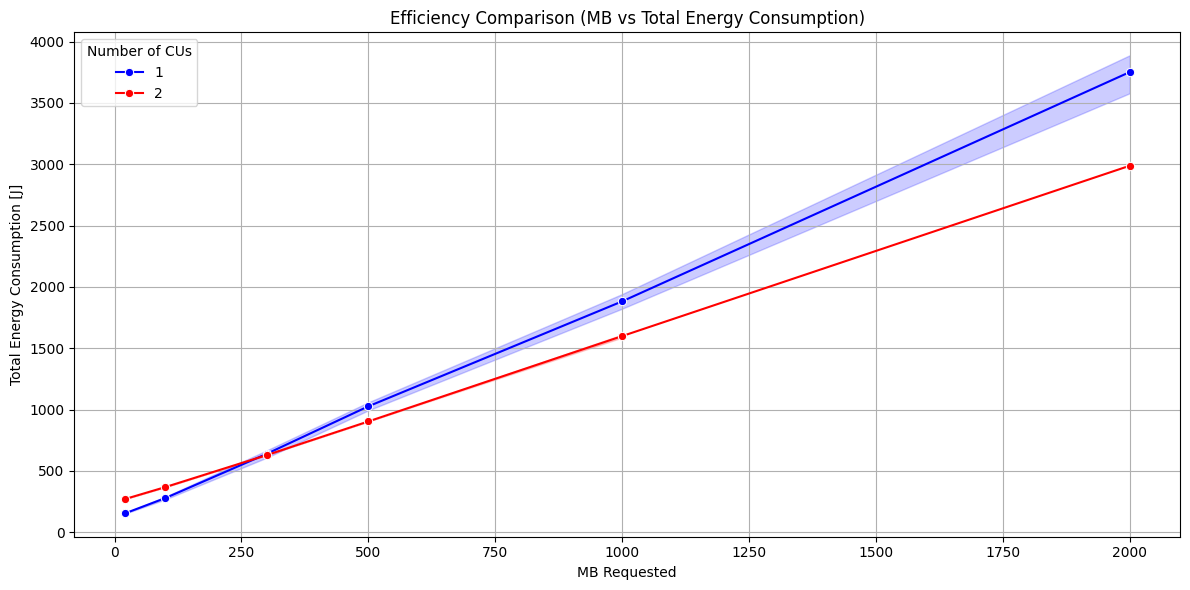

In [148]:
# Efficiency Plot
def plot_efficiency(df_experiment):
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(
        data=df_experiment, 
        x='Mbps requested', 
        y='total_energy_consumption', 
        hue='num_cus', 
        marker='o', 
        palette=[ 'blue','red',]
    )
    
    plt.title('Efficiency Comparison (MB vs Total Energy Consumption)')
    plt.xlabel('MB Requested')
    plt.ylabel('Total Energy Consumption [J]')
    plt.legend(title='Number of CUs', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the functions to plot
plot_efficiency(df_experiment)


In [143]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Get unique Mbps requested values
# mbps_values = sorted(df_experiment['Mbps requested'].unique())

# # Set the grid size based on the number of unique Mbps requested values
# num_plots = len(mbps_values)
# cols = 2  # Number of columns in the grid
# rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

# # Create subplots
# fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
# axes = axes.flatten()  # Flatten to easily iterate through axes

# # Loop through each Mbps requested value and create a plot
# for i, mbps in enumerate(mbps_values):
#     # Filter the DataFrame for the current Mbps requested
#     df = df_experiment[df_experiment['Mbps requested'] == mbps].copy()

#     # Aggregate the data for each maxrate and num_cus combination
#     bar_data_with_host = df.groupby(['maxrate', 'num_cus'])['total_energy_consumption_with_host_J'].mean().unstack()

#     # Plot the updated bar chart
#     ax = bar_data_with_host.plot(kind='bar', ax=axes[i], width=0.8, color=['red', 'blue'])

#     # Add labels, title, and legend
#     ax.set_xlabel('Max Rate (Mbps)', fontsize=10)
#     ax.set_ylabel('Total Energy Consumption (J)', fontsize=10)
#     ax.set_title(f'Mb Requested: {mbps}', fontsize=12)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate x-axis labels for better readability
#     ax.legend(['1 CU', '2 CUs'], title='Configuration')

# # Turn off unused subplots if there are any
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# # Adjust layout
# plt.tight_layout()
# plt.show()


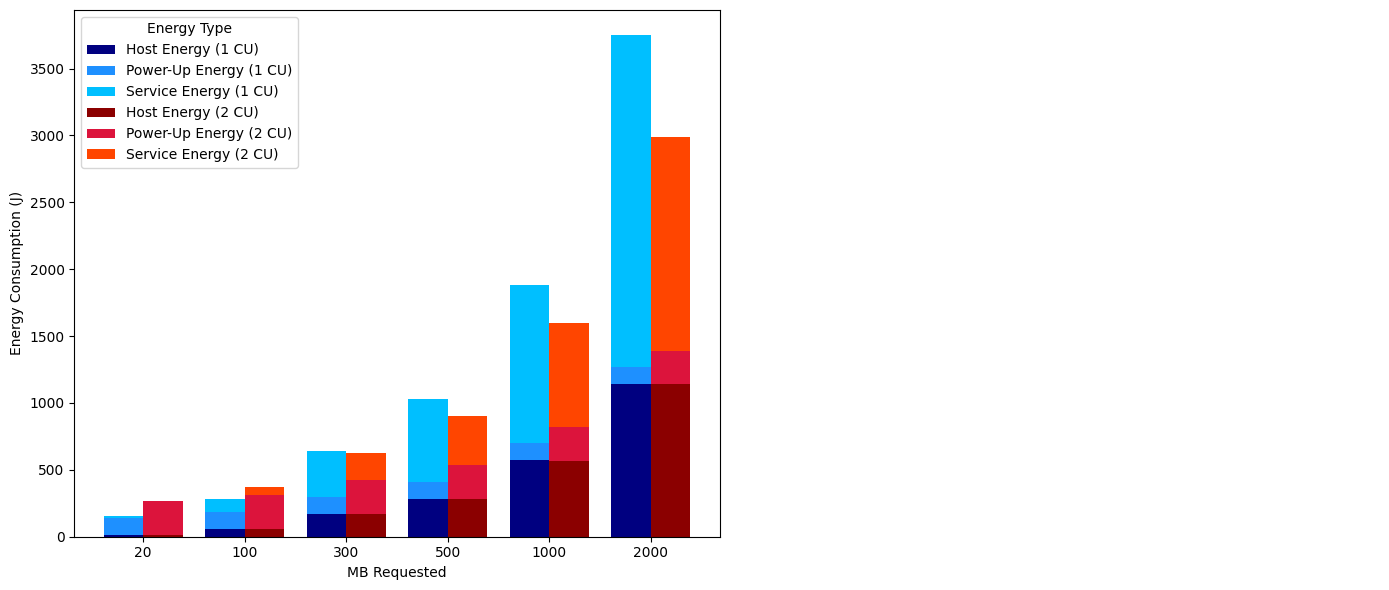

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get unique maxrate values and sort them
maxrate_values = sorted(df_experiment['maxrate'].unique())

# Set the grid size based on the number of unique maxrate values
num_plots = len(maxrate_values)
cols = 2  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Define color mapping for bars
color_map = {
    1: ['navy', 'deepskyblue', 'dodgerblue'],  # Higher contrast blues for 1 CU
    2: ['darkred', 'orangered', 'crimson'],    # Higher contrast reds for 2 CUs
}

bar_width = 0.35  # Width of each bar
bar_gap = 0.2  # Space between different x-value groups

# Loop through each maxrate value and create a plot
for i, maxrate in enumerate(maxrate_values):
    # Filter the DataFrame for the current maxrate
    df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

    # Aggregate the data for each Mbps requested and num_cus combination
    energy_data = df.groupby(['Mbps requested', 'num_cus'])[
        ['host_energy_consumption', 'service_energy_consumption_J', 'powerup_energy_consumption']
    ].mean().unstack()

    # Get the current axis
    ax = axes[i]

    # Calculate x positions with added gaps
    x_positions = np.arange(len(energy_data.index)) * (2 * bar_width + bar_gap)

    # Plot bars for each CU configuration
    for j, num_cus in enumerate(energy_data.columns.levels[1]):
        data = energy_data.xs(num_cus, level='num_cus', axis=1)  # Extract data for num_cus
        ax.bar(
            x_positions + j * bar_width,
            data['host_energy_consumption'],
            width=bar_width,
            color=color_map[num_cus][0],
            label=f'Host Energy ({num_cus} CU)' if i == 0 else "",
        )
        ax.bar(
            x_positions + j * bar_width,
            data['powerup_energy_consumption'],
            width=bar_width,
            bottom=data['host_energy_consumption'],
            color=color_map[num_cus][2],  # Use the third color for Power-Up Energy
            label=f'Power-Up Energy ({num_cus} CU)' if i == 0 else "",
        )
        ax.bar(
            x_positions + j * bar_width,
            data['service_energy_consumption_J'],
            width=bar_width,
            bottom=data['host_energy_consumption'] + data['powerup_energy_consumption'],
            color=color_map[num_cus][1],  # Use the second color for Service Energy
            label=f'Service Energy ({num_cus} CU)' if i == 0 else "",
        )

    # Add labels, title, and legend
    ax.set_xlabel('MB Requested', fontsize=10)
    ax.set_ylabel('Energy Consumption (J)', fontsize=10)
    # ax.set_title(f'Max Rate: {maxrate} Mbps', fontsize=12)
    ax.set_xticks(x_positions + bar_width / 2)
    ax.set_xticklabels(energy_data.index, rotation=0)

    # Add the legend only once per plot
    if i == 0:
        ax.legend(title='Energy Type')

# Turn off unused subplots if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


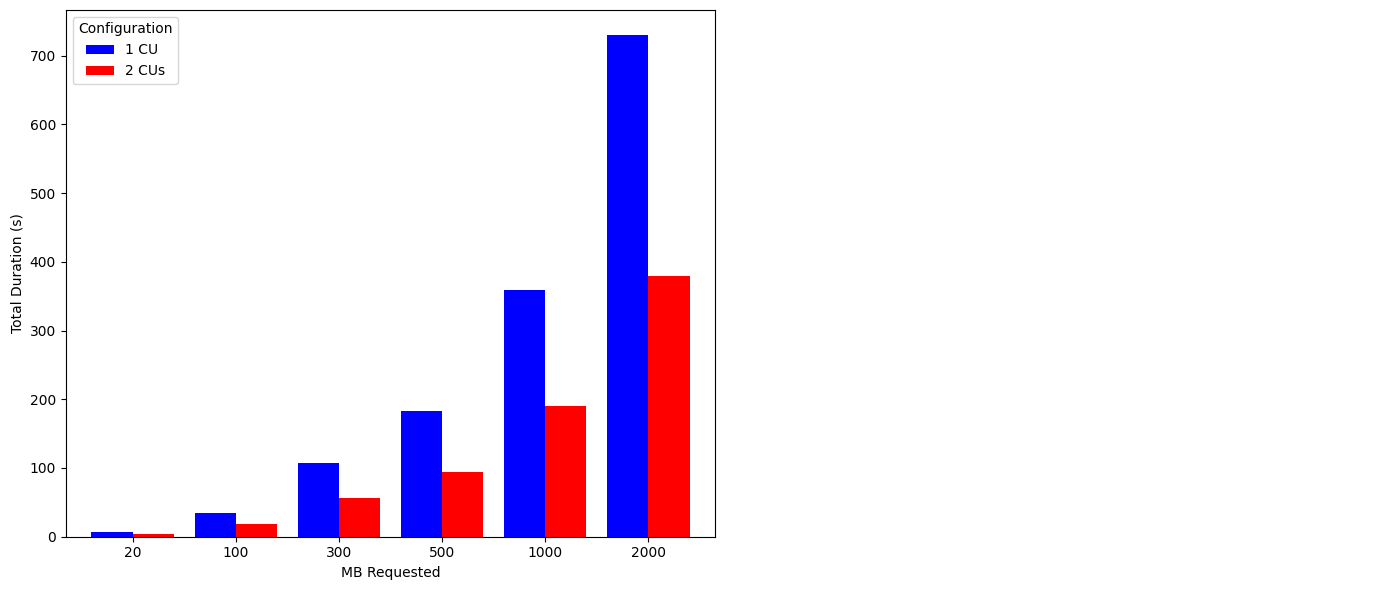

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Get unique maxrate values and sort them
maxrate_values = sorted(df_experiment['maxrate'].unique())

# Set the grid size based on the number of unique maxrate values
num_plots = len(maxrate_values)
cols = 2  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Loop through each maxrate value and create a plot
for i, maxrate in enumerate(maxrate_values):
    # Filter the DataFrame for the current maxrate
    df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

    # Calculate the combined duration for each row
    df['total_duration'] = df['duration_1'] + df['duration_2']

    # Aggregate the data for each Mbps requested and num_cus combination
    bar_data_with_host = df.groupby(['Mbps requested', 'num_cus'])['total_duration'].mean().unstack()

    # Plot the updated bar chart
    ax = bar_data_with_host.plot(kind='bar', ax=axes[i], width=0.8, color=[ 'blue', 'red',])

    # Add labels, title, and legend
    ax.set_xlabel('MB Requested', fontsize=10)
    ax.set_ylabel('Total Duration (s)', fontsize=10)
    # ax.set_title(f'Max Rate: {maxrate} Mbps', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate x-axis labels for better readability
    ax.legend(['1 CU', '2 CUs'], title='Configuration')

# Turn off unused subplots if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


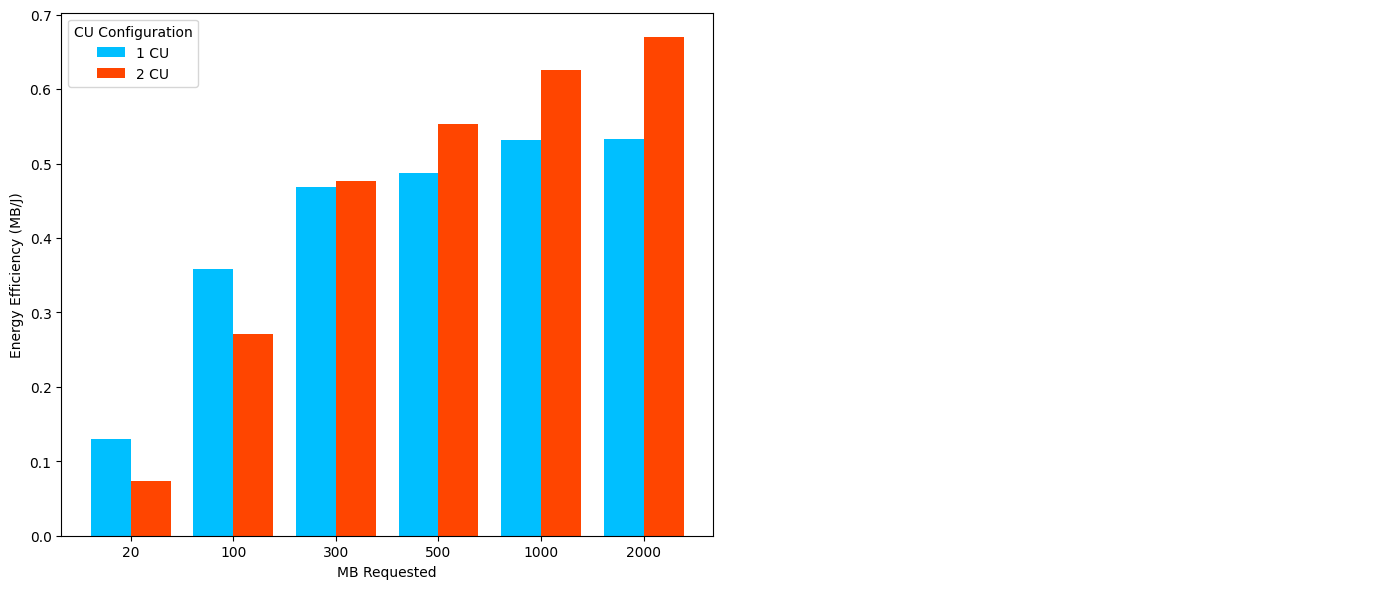

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get unique maxrate values and sort them
maxrate_values = sorted(df_experiment['maxrate'].unique())

# Set the grid size based on the number of unique maxrate values
num_plots = len(maxrate_values)
cols = 2  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Define color mapping for bars
color_map = {
    1: 'deepskyblue',  # Color for 1 CU
    2: 'orangered',    # Color for 2 CUs
}

bar_width = 0.35  # Width of each bar
bar_gap = 0.2  # Space between different x-value groups

# Loop through each maxrate value and create a plot
for i, maxrate in enumerate(maxrate_values):
    # Filter the DataFrame for the current maxrate
    df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

    # Aggregate the data for each Mbps requested and num_cus combination
    aggregated_data = df.groupby(['Mbps requested', 'num_cus'])[
        ['host_energy_consumption', 'service_energy_consumption_J', 'powerup_energy_consumption']
    ].mean()

    # Calculate total energy consumption
    aggregated_data['total_energy'] = (
        aggregated_data['host_energy_consumption'] +
        aggregated_data['service_energy_consumption_J'] +
        aggregated_data['powerup_energy_consumption']
    )

    # Calculate energy efficiency (Mbps requested / total energy)
    aggregated_data['energy_efficiency'] = aggregated_data.index.get_level_values(0) / aggregated_data['total_energy']

    # Unstack the data for easier plotting
    efficiency_data = aggregated_data['energy_efficiency'].unstack()

    # Get the current axis
    ax = axes[i]

    # Calculate x positions with added gaps
    x_positions = np.arange(len(efficiency_data.index)) * (bar_width * len(efficiency_data.columns) + bar_gap)

    # Plot bars for each CU configuration
    for j, num_cus in enumerate(efficiency_data.columns):
        ax.bar(
            x_positions + j * bar_width,
            efficiency_data[num_cus],
            width=bar_width,
            color=color_map[num_cus],
            label=f'{num_cus} CU' if i == 0 else ""
        )

    # Add labels, title, and legend
    ax.set_xlabel('MB Requested', fontsize=10)
    ax.set_ylabel('Energy Efficiency (MB/J)', fontsize=10)
    # ax.set_title(f'Max Rate: {maxrate} Mbps', fontsize=12)
    ax.set_xticks(x_positions + (len(efficiency_data.columns) - 1) * bar_width / 2)
    ax.set_xticklabels(efficiency_data.index, rotation=0)

    # Add the legend only once for the top-left plot
    if i == 0:
        ax.legend(title='CU Configuration')

# Turn off unused subplots if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


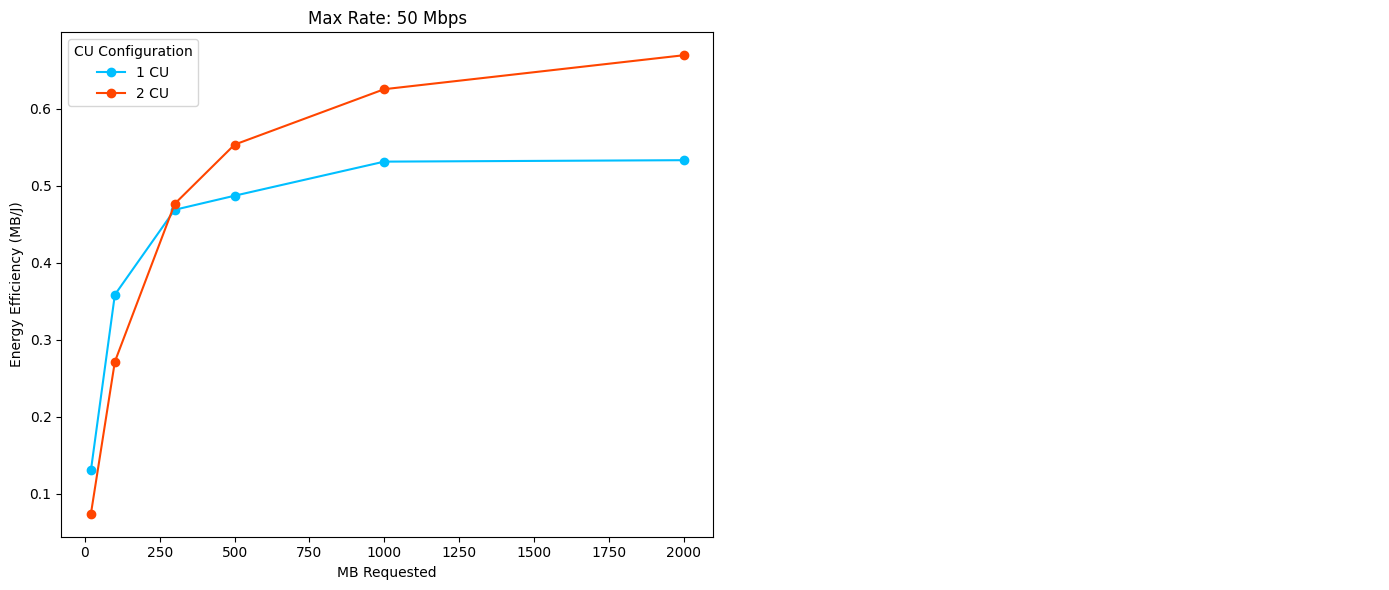

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get unique maxrate values and sort them
maxrate_values = sorted(df_experiment['maxrate'].unique())

# Set the grid size based on the number of unique maxrate values
num_plots = len(maxrate_values)
cols = 2  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Define color mapping for lines
color_map = {
    1: 'deepskyblue',  # Color for 1 CU
    2: 'orangered',    # Color for 2 CUs
}

# Loop through each maxrate value and create a plot
for i, maxrate in enumerate(maxrate_values):
    # Filter the DataFrame for the current maxrate
    df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

    # Aggregate the data for each Mbps requested and num_cus combination
    aggregated_data = df.groupby(['Mbps requested', 'num_cus'])[ 
        ['host_energy_consumption', 'service_energy_consumption_J', 'powerup_energy_consumption']
    ].mean()

    # Calculate total energy consumption
    aggregated_data['total_energy'] = (
        aggregated_data['host_energy_consumption'] +
        aggregated_data['service_energy_consumption_J'] +
        aggregated_data['powerup_energy_consumption']
    )

    # Calculate energy efficiency (Mbps requested / total energy)
    aggregated_data['energy_efficiency'] = aggregated_data.index.get_level_values(0) / aggregated_data['total_energy']

    # Unstack the data for easier plotting
    efficiency_data = aggregated_data['energy_efficiency'].unstack()

    # Get the current axis
    ax = axes[i]

    # Plot lines for each CU configuration
    for j, num_cus in enumerate(efficiency_data.columns):
        ax.plot(
            efficiency_data.index,  # X values (MB Requested)
            efficiency_data[num_cus],  # Y values (Energy Efficiency)
            marker='o',
            color=color_map[num_cus],
            label=f'{num_cus} CU' if i == 0 else ""
        )

    # Add labels, title, and legend
    ax.set_xlabel('MB Requested', fontsize=10)
    ax.set_ylabel('Energy Efficiency (MB/J)', fontsize=10)
    ax.set_title(f'Max Rate: {maxrate} Mbps', fontsize=12)

    # Add the legend only once for the top-left plot
    if i == 0:
        ax.legend(title='CU Configuration')

# Turn off unused subplots if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()
